# Classificação multiclasse

Primeiramente devemos ler os nossos dados

In [5]:
import pandas as pd

data_path = '../data/Dry_Bean_Dataset.xlsx'
beans_data = pd.read_excel(data_path)

sample = beans_data.sample(3)
print(sample)

       Bean ID    Area  Perimeter  MajorAxisLength  MinorAxisLength  \
3536      3537  164326   1532.137       575.688180       366.351800   
3946      3947   61204    953.807       376.089729       208.612182   
11944    11945   32279    670.977       250.820564       164.181397   

       AspectRation  Eccentricity  ConvexArea  EquivDiameter    Extent  \
3536       1.571408      0.771382      165918     457.412682  0.842464   
3946       1.802818      0.832059       61712     279.154712  0.767150   
11944      1.527704      0.755995       32662     202.728635  0.757190   

       Solidity  roundness  Compactness  ShapeFactor1  ShapeFactor2  \
3536   0.990405   0.879672     0.794549      0.003503      0.000861   
3946   0.991768   0.845412     0.742256      0.006145      0.001151   
11944  0.988274   0.900979     0.808262      0.007770      0.002046   

       ShapeFactor3  ShapeFactor4     Class  
3536       0.631309      0.992044    BOMBAY  
3946       0.550943      0.993250      CA

In [7]:
X = beans_data.iloc[:,1:-1]
y = beans_data.Class

print(X.sample(1))

        Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
10135  23459    556.684       200.293385       149.229973      1.342179   

       Eccentricity  ConvexArea  EquivDiameter   Extent  Solidity  roundness  \
10135      0.667001       23690      172.82629  0.75772  0.990249   0.951266   

       Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  
10135     0.862866      0.008538       0.00292      0.744537      0.999302  


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

## Método One versus Rest

In [10]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

ovr = OneVsRestClassifier(model)

ovr.fit(X_train,y_train)

y_pred = ovr.predict(X_test)

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.82      0.88       331
      BOMBAY       1.00      0.96      0.98       121
        CALI       0.91      0.87      0.89       408
    DERMASON       0.91      0.82      0.86       874
       HOROZ       0.92      0.91      0.92       470
       SEKER       0.95      0.93      0.94       513
        SIRA       0.71      0.90      0.79       686

    accuracy                           0.87      3403
   macro avg       0.91      0.89      0.89      3403
weighted avg       0.89      0.87      0.88      3403

Confusion matrix:
[[270   0  25   0   2   2  32]
 [  0 116   4   0   0   1   0]
 [  9   0 354   0  21   1  23]
 [  0   0   0 715   4  15 140]
 [  1   0   4   6 430   0  29]
 [  2   0   0   8   0 476  27]
 [  0   0   1  53   9   7 616]]


O grupo optou por fazer a própria implementação do método

Criação dos modelos

In [34]:
import numpy as np

models = []

for label in np.unique(y):
    filter = lambda r:(1 if r == label else -1)
    y_train_class = np.array([filter(row) for row in y_train])
    y_test_class = np.array([filter(row) for row in y_test])

    model = DecisionTreeClassifier()
    model.fit(X_train,y_train_class)
    models.append((model,label))

Predição

In [35]:
y_pred = np.empty(len(y_test), dtype='O')
max_prob = np.zeros(len(y_train))

for model in models:
    probability = model[0].predict_proba(X_test)[:,1]
    for i,prob in enumerate(probability):
        if max_prob[i] <= prob:
            max_prob[i] = prob
            y_pred[i] = model[1]

Resultados

In [36]:
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.81      0.88       331
      BOMBAY       1.00      0.98      0.99       121
        CALI       0.92      0.88      0.90       408
    DERMASON       0.91      0.82      0.86       874
       HOROZ       0.92      0.92      0.92       470
       SEKER       0.94      0.93      0.94       513
        SIRA       0.72      0.89      0.80       686

    accuracy                           0.88      3403
   macro avg       0.91      0.89      0.90      3403
weighted avg       0.89      0.88      0.88      3403

Confusion matrix:
[[269   0  23   0   3   3  33]
 [  0 118   2   0   0   1   0]
 [  9   0 357   0  20   1  21]
 [  0   0   0 719   4  16 135]
 [  0   0   6   7 434   0  23]
 [  2   0   0   8   0 477  26]
 [  2   0   1  55   9   7 612]]


Testar acuracia de varios modelos

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

modelos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Logistic Regression', LogisticRegression(max_iter=300)),
    ('Naive Bayes', GaussianNB())
]


acuracias = []


for nome, modelo in modelos:
    ovr = OneVsRestClassifier(modelo)
    ovr.fit(X_train, y_train)
    y_pred = ovr.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Vamos plotar

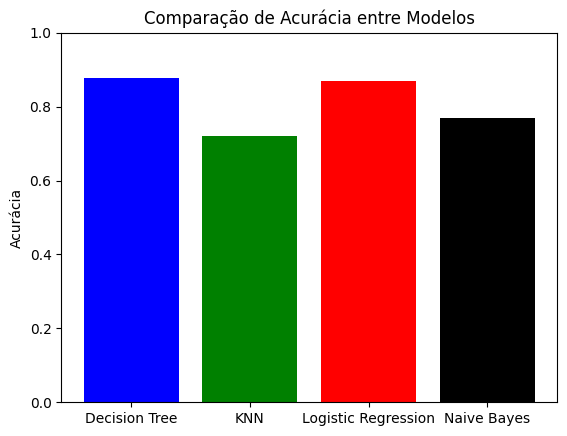

In [41]:
import matplotlib.pyplot as plt

nomes_modelos, valores_acuracia = zip(*acuracias)
plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()
